<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/scripts/VAE_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE

- 元論文 Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114 (2013)

AutoEncoderの構造にEncoderとDecoderの中間での出力を特定の確率分布に近似させるのが**VAE(Variational Auto Encoder)**。

雑に言っちゃえばこんな感じ。この中間のパラメータを **潜在変数** と呼んだりする。 

```bash
Input X -> Encoder -> p(z|x) -> Decoder X
```
<img src='assets/vae.png' width=400>

VAEでは確率分布（黄色）を平均μ, 標準偏差σのガウス分布で近似する。つまり、Encoderでは最後にMLPを２つ用意し、それぞれの出力をμとσとして扱う。Decoderの入力にはN(μ, σ)からサンプリングしたノイズzをMLPでデコードする。

```bash
Input X -> Encoder ->  mu    ->   z ~N(mu, sigma) -> Decoder -> X
                         |-----> sigma  -----------------^
```
<img src='assets/vae_3.png' width=400>

だけど、ガウス分布からサンプリングするネットワークを組むと、学習（誤差の逆伝搬）ができなくなる。そこで、Parameterization Trickという方法を使う。Parameterization Trickでは、サンプリングする代わりに、μとσから直接的にzを求める。zは次式で計算される。

εは平均0、標準偏差1のガウス分布からサンプリングするものだけど、Encoderへの逆伝搬には影響しない。

$
z = \mu + \epsilon e^{0.5 + \sigma}, \epsilon \sim N(0, 1)
$

つまり、 VAEの全体的な構造はこうなる。ここでは潜在変数を２次元にしている。（MNISTでは２次元でなんとかなるが、Cifar10のように画像の分散が大きくなると、潜在変数も大きくする必要がある）

```bash
Input (784) -> Linear (256) -> Linear(2) -> Linear(2) -> Linear(256) -> Output(784)
                             |-------------> Linear(2)  --------^

```

<img src='assets/vae_2.png' width=400>

VAE の Loss は *Reconstruction Loss* と *KLDivergence* の２つの Multi task loss になる。 LreconstructionはAutoEncoderのロス（画像を復元するための入力画像と出力画像のCrossEntropy)。KLDは潜在変数をある特定の値に近づけるために導入されている。

ここでは潜在変数となるμ、σをそれぞれ0,1に近づけるために次式で定義される。

$ Loss = L_{Reconstruction} + D_{KL}$

$D_{KL} = - \frac{1}{2}(1 + \sigma - \mu^2 - e^{\sigma})$


In [1]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint
import cv2

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(10) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 28
cfg.INPUT_WIDTH = 28
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.VAE_Z_DIM = 2
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.VAE_KLD_BALANCE = 1 # loss = lossReconstruction + this * loss_KLD

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'VAE_mnist'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt' # save model to this path
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000 # save model in each this
cfg.TRAIN.ITERATION = 3_000 # max training iteration
cfg.TRAIN.MINIBATCH = 512
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'weight_decay' : 1e-5}

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 10_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_E_PATH = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') # use this trained path
cfg.TEST.MODEL_D_PATH = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 30
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'AE_DIM': 32,
 'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 10),
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 1,
 'INPUT_HEIGHT': 28,
 'INPUT_MODE': None,
 'INPUT_WIDTH': 28,
 'OUTPUT_CHANNEL': 1,
 'OUTPUT_CMAP': 'gray',
 'OUTPUT_HEIGHT': 28,
 'OUTPUT_MODE': None,
 'OUTPUT_WIDTH': 28,
 'PREFIX': 'VAE_mnist',
 'TEST': {'DATA_PATH': './data',
          'ITERATION': 2,
          'MAX_SAMPLES': 30,
          'MINIBATCH': 10,
          'MODEL_D_PATH': 'models/VAE_mnist_D_final.pt',
          'MODEL_E_PATH': 'models/VAE_mnist_E_final.pt',
          'RESULT_IMAGE_PATH': 'result/VAE_mnist_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPLAY_ITERATION_INTERVAL': 1000,
           'ITERATION': 3000,
           'LEARNING_PARAMS': {'lr': 0.001, 'weight_decay': 1e-05},
     

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class VAE_Encoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        dim = cfg.AE_DIM

        self.module = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, dim * 8),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 8, dim * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 4, dim * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 2, dim),
            torch.nn.ReLU(),
        )

        self.encoder_mu = torch.nn.Linear(dim, cfg.VAE_Z_DIM)
        self.encoder_sigma = torch.nn.Linear(dim, cfg.VAE_Z_DIM)
        
    def forward(self, x):
        x = self.module(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma
    
    
class VAE_Sampler(torch.nn.Module):
    def __init__(self):
        super(VAE_Sampler, self).__init__()
        
    def forward(self, x):
        mu, logvar = x
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
class VAE_Decoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        dim = cfg.AE_DIM

        self.module = torch.nn.Sequential(
            torch.nn.Linear(cfg.VAE_Z_DIM, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, dim * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 2, dim * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 4, dim * 8),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 8, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL),
            torch.nn.Tanh(),
        )
        
    def forward(self, x):
        return self.module(x)

def loss_KLDivergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

def result_show(Xs, ys, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = ys.detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()


#---
# preprocess for torchvision.datasets
#---
def preprocess(Xs, cfg, mode, hf=False, vf=False, rot=False):
    xs = []

    for x in Xs:
        # resize
        x = cv2.resize(x, (cfg.OUTPUT_WIDTH, cfg.OUTPUT_HEIGHT)).astype(np.float32)
        
        # channel BGR -> Gray
        if mode == 'GRAY':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = np.expand_dims(x, axis=-1)
        elif mode == 'EDGE':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = cv2.Canny(x, 100, 150)
            x = np.expand_dims(x, axis=-1)

        # horizontal flip
        if hf and np.random.rand() < 0.5:
            x = x[:, ::-1]

        # vertical flip
        if vf and np.random.rand() < 0.5:
            x = x[::-1]

        # rotation
        if rot != False:
            rot = np.random.randint(0, 360, 1) // cfg.TRAIN.DATA_ROTATION * cfg.TRAIN.DATA_ROTATION

            scale = 1

            _h, _w = x.shape[:2]
            _c = 1
            if len(x.shape) == 3:
                _c = x.shape[2]

            max_side = max(_h, _w)
            tmp = np.zeros((max_side, max_side, _c))
            tx = int((max_side - _w) / 2)
            ty = int((max_side - _h) / 2)
            tmp[ty: ty+_h, tx: tx+_w] = x.copy()
            M = cv2.getRotationMatrix2D((max_side / 2, max_side / 2), rot, scale)
            _x = cv2.warpAffine(tmp, M, (max_side, max_side))
            x = _x[tx:tx+_w, ty:ty+_h]

        if mode == 'CLASS_LABEL':
            _x = x
            x = np.zeros((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.CLASS_NUM), dtype=np.int)

            for i, (_, vs) in enumerate(cfg.CLASS_LABEL.items()):
                ind = (_x[..., 0] == vs[0]) * (_x[..., 1] == vs[1]) * (_x[..., 2] == vs[2])
                x[..., i][ind] = 1

        else:
            # normalization [0, 255] -> [-1, 1]
            x = x / 255

            # channel BGR -> RGB
            #if mode in ['RGB']:
            #    x = x[..., ::-1]

        xs.append(x)
                
    xs = np.array(xs, dtype=np.float32)
    if cfg.CHANNEL_AXIS == 1:
        if len(xs.shape) == 4:
            xs = xs.transpose(0, 3, 1, 2)
        else:
            xs = np.expand_dims(xs, axis=1)
    else:
        if len(xs.shape) == 3:
            xs = np.expand_dims(xs, axis=-1)

    return xs

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 2]              66
           Linear-11                    [-1, 2]              66
Total params: 244,324
Trainable params: 244,324
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter:1000, Loss:70766.1719 (Recon:67755.6641, KLD:3010.5107)


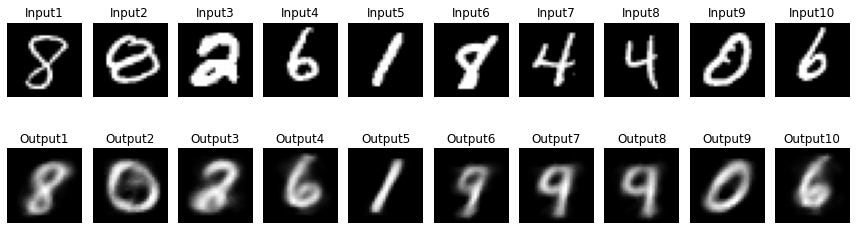

Iter:2000, Loss:65812.0547 (Recon:62524.5977, KLD:3287.4551)


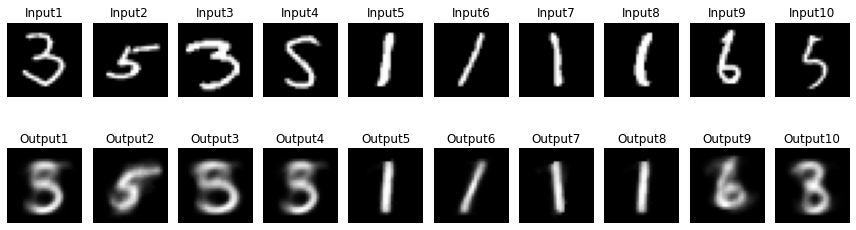

Iter:3000, Loss:64510.9102 (Recon:60936.2031, KLD:3574.7075)


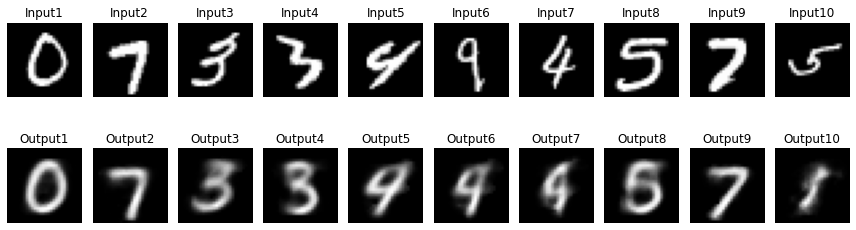

final paramters were saved toE >> models/VAE_mnist_E_final.pt, D >> models/VAE_mnist_D_final.pt
loss was saved to >> result/VAE_mnist_loss.txt


In [5]:
# train
def train():
    # model
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH), device=cfg.DEVICE_TYPE)
    summary(model_decoder, (cfg.VAE_Z_DIM, ),  device=cfg.DEVICE_TYPE)
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    ds = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    Xs_data = Xs_data.unsqueeze(1)
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)

    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    loss_fn = torch.nn.MSELoss(reduction='sum')

    list_iter = []
    list_loss = []
    list_loss_RECONSTRUCTION = []
    list_loss_KLD = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        mb_inds = batch_gen()

        # train
        opt.zero_grad()

        # sample X, y
        Xs = Xs_data[mb_inds]

        # forward
        mu, sigma = model_encoder(Xs)
        z = model_sampler([mu, sigma])
        ys = model_decoder(z)
        
        # loss
        loss_recon = loss_fn(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        
        # loss KLDivergence
        loss_kld = loss_KLDivergence(mu, sigma)
        loss = loss_recon + cfg.VAE_KLD_BALANCE * loss_kld

        # update
        loss.backward()
        opt.step()

        progres_bar += '|'

        _loss = loss.item()
        _loss_recon = loss_recon.item()
        _loss_kld = loss_kld.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_loss_RECONSTRUCTION.append(_loss_recon)
                list_loss_KLD.append(_loss_kld)

        print('\r' + 'Loss:{:.4f} '.format(_loss) + progres_bar, end='')
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} (Recon:{:.4f}, KLD:{:.4f})'.format(i + 1, _loss, _loss_recon, _loss_kld))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
            save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model_encoder.state_dict(), save_path_E)
            torch.save(model_decoder.state_dict(), save_path_D)
            print('save E >> {}, D >> {}'.format(save_path_E, save_path_D))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                Xs, ys, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                Xs, ys, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final')
    save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(model_encoder.state_dict(), save_path_E)
    torch.save(model_decoder.state_dict(), save_path_D)
    print('final paramters were saved toE >> {}, D >> {}'.format(save_path_E, save_path_D))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'loss_reconstruction' : list_loss_RECONSTRUCTION, 
                           'loss_KLD' : list_loss_KLD})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

# Plot loss

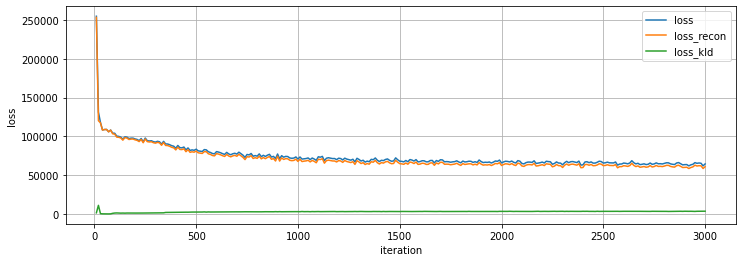

In [6]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df['iteration'], df['loss'], label='loss')
    ax.plot(df['iteration'], df['loss_reconstruction'], label='loss_recon')
    ax.plot(df['iteration'], df['loss_KLD'], label='loss_kld')

    ax.legend(loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    plt.grid()
    plt.show()

plot_process()

## Test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iteration : 1


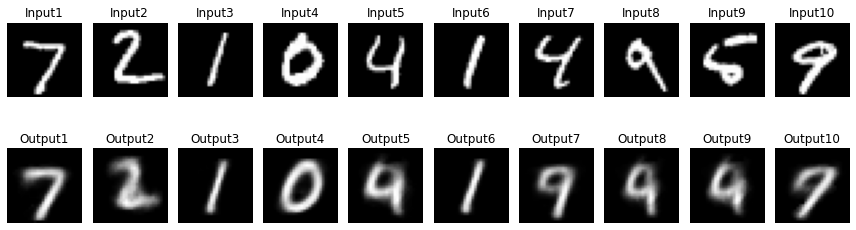

iteration : 2


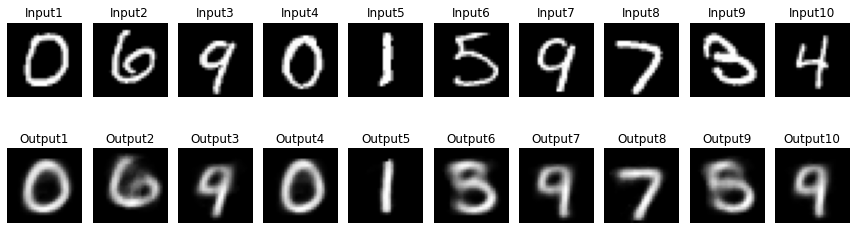

iteration : 3


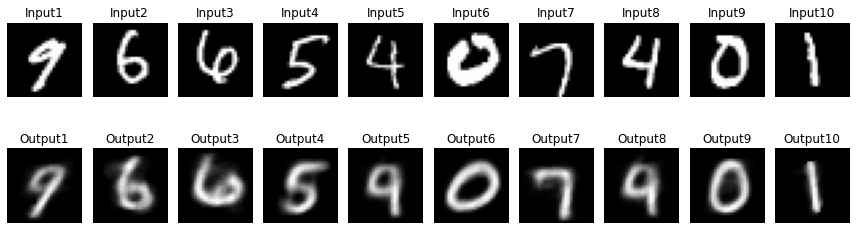

In [7]:
# test
def test():
    #print('-' * 20　+ '\ntest function\n' + '-' * 20)
    
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    ds = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    Xs_data = Xs_data.unsqueeze(1)
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    
    Test_Num = min(data_num, cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i, mbi in enumerate(range(0, Test_Num, cfg.TEST.MINIBATCH)):
            mb_ind = np.arange(mbi, min(mbi + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = Xs_data[mb_ind]
            ys = model(Xs)

            print('iteration :', i+ 1)
            result_show(Xs, ys, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

## Latent Space

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


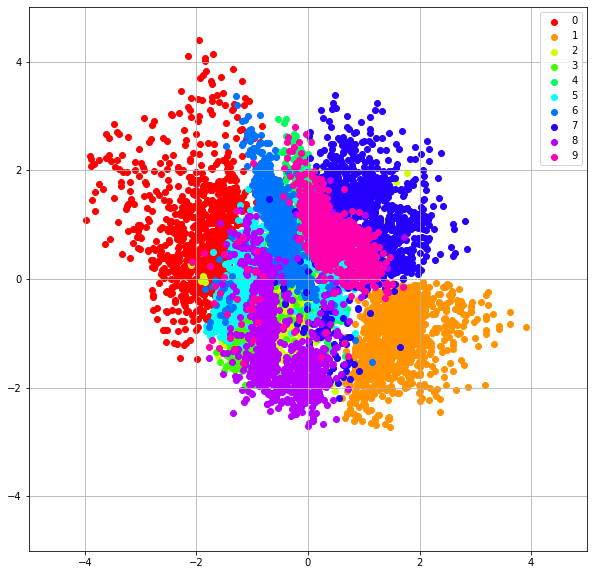

In [8]:
import matplotlib.cm

def latent_show():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()

    plt.figure(figsize=[10, 10])
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
  
    ds = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    Xs_data = Xs_data.unsqueeze(1)
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _Xs = Xs_data[ts_data == class_i]

            Test_Num = len(_Xs)
            
            z1 = np.ndarray(shape=[0])
            z2 = np.ndarray(shape=[0])
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = _Xs[mb_ind]
                
                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                z = z.detach().cpu().numpy()
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    plt.grid()
    plt.legend()
    plt.savefig('result/vae_latent_show.png')
    plt.show()
    
latent_show()

## Latent control

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


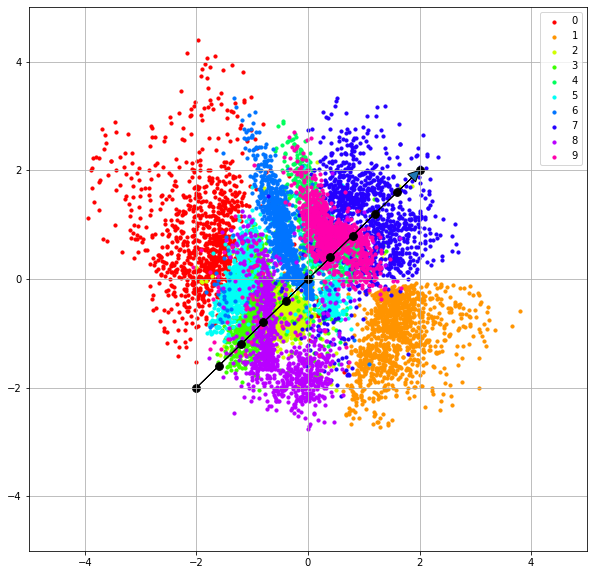

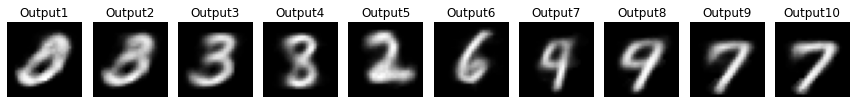

In [9]:
def latent_control():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    plt.figure(figsize=[10, 10])
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    
    # split number (show image number)
    show_num = 10

    # latent lower and upper bound
    z1_lower, z1_upper = -2, 2
    z2_lower, z2_upper = -2, 2

    div1 = (z1_upper - z1_lower) / show_num
    div2 = (z2_upper - z2_lower) / show_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
    
    ds = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    Xs_data = Xs_data.unsqueeze(1)
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _Xs = Xs_data[ts_data == class_i]

            Test_Num = len(_Xs)
            
            z1 = np.ndarray(shape=[0])
            z2 = np.ndarray(shape=[0])
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = _Xs[mb_ind]         

                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                z = z.detach().cpu().numpy()
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i, s=10)
    
    # draw sampling position
    #plt.plot(np.arange(z1_lower, z1_upper, 0.01), np.arange(z2_lower, z2_upper, 0.01), linewidth=3)
    plt.arrow(z1_lower, z2_lower, z1_upper - z1_lower, z2_upper - z2_lower, length_includes_head=True,
          head_width=0.2, head_length=0.2)
    plt.scatter(z1s, z2s, color='black', s=60)
    plt.grid()
    plt.legend()
    
    plt.figure(figsize=[12, 12])
    
    
    with torch.no_grad():
        for i in range(show_num):
            # get latent vector
            z = [[z1s[i], z2s[i]]]
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            _y = ys[0]
            plt.subplot(1, show_num, i + 1)
            plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
            plt.axis('off')
            plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    #plt.savefig('result/vae_latent_change.png')
    plt.show()
    
latent_control()

## Show Latent map

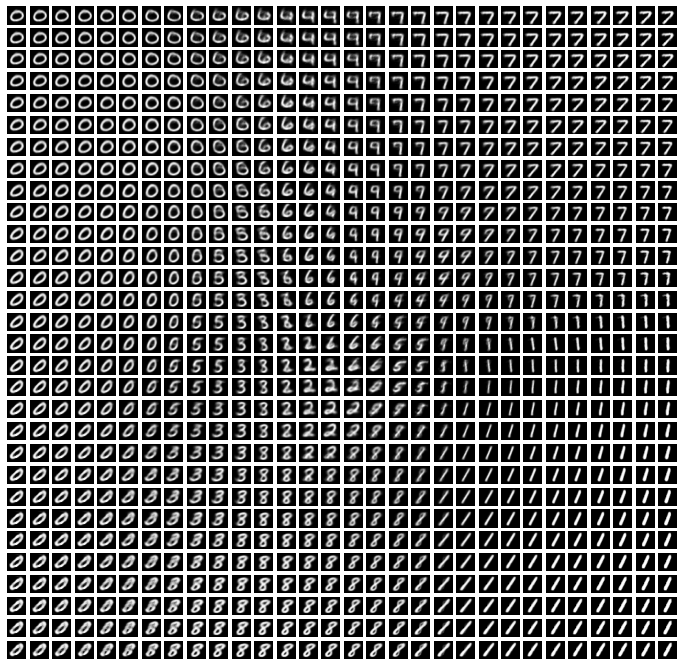

In [10]:
def latent_map():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()

    plt.figure(figsize=[12, 12])
    
    # split number (show image number)
    z1_num = 30
    z2_num = 30

    # latent lower and upper bound
    z1_lower, z1_upper = -3, 3
    z2_lower, z2_upper = -3, 3
    
    div1 = (z1_upper - z1_lower) / z1_num
    div2 = (z2_upper - z2_lower) / z2_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    with torch.no_grad():
        for i in range(z2_num):
            z = [[_z1, z2s[i]] for _z1 in z1s]

            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
                
            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            for j in range(z1_num):
                _y = ys[j]
                plt.subplot(z2_num, z1_num, j + (z2_num - 1 - i) * z1_num + 1)
                plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
                plt.axis('off')
            
    plt.show()
    
latent_map()